In [324]:
### Import the necessary libraries

import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from sklearn.metrics import make_scorer, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [325]:

## defining the function 'load_data' to red our data in

def load_data(path, date = None):
    '''Takes in the argument file path and date, where date is False by default'''

    if date:
        date = date
        data = pd.read_csv(path, parse_dates = date, na_values = ['Null', 'nan'], infer_datetime_format = True) 
        print('Loading Data...............')
        print('Data Loaded with Date')
        
    else:
        data = pd.read_csv(path, na_values = ['Null', 'nan'])
        print('Loading Data...............')
        print('Data Loaded without Date')
    return data

train_path = 'Xente/training.csv'
train_xe = load_data(train_path, date = ['TransactionStartTime'])

Loading Data...............
Data Loaded with Date


In [326]:
train_xe.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21,2,0


Text(0.5,1,'Fraudulent VS Non-Fraudulent')

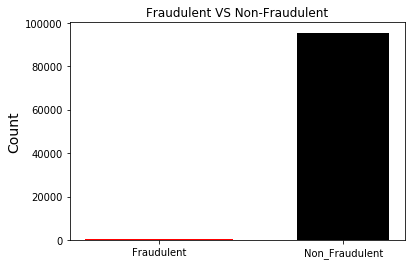

In [328]:
### Checking if the data is balanced or inbalanced

#Visualising Fraudulent and non-fraudulent cases
plt.bar("Fraudulent", train["FraudResult"].value_counts()[1], color="red")
plt.bar("Non_Fraudulent", train["FraudResult"].value_counts()[0], width=0.5, color="black")
plt.ylabel("Count", fontsize=14)
plt.title("Fraudulent VS Non-Fraudulent")

In [329]:
## Dropping the id columns and the unchanging columns

ids = ['TransactionId', 'CurrencyCode', 'CountryCode']
train_xe.drop(ids, inplace = True, axis = 1)

## Performing feature enginering on the TransactionStartTime column
train_xe['Fraud_time'] = train_xe['TransactionStartTime'].dt.time
from datetime import time
def time_of_the_day(frame):
    if time(0, 0, 0) < frame < time(4, 59, 0):
        return 'Midnight'
    if time(5, 0, 0) < frame < time(11, 59, 0):
        return 'Morning'
    if time(12, 0, 0) < frame < time(18, 0, 0):
        return 'Afternoon'
    if time(18, 1, 0) < frame < time(21, 59, 0):
        return 'Night'
train_xe['time_of_the_day'] = train_xe['Fraud_time'].apply(time_of_the_day)

In [330]:
## One hot encoding the categorical columns
product_cat = pd.get_dummies(train_xe['ProductCategory'])
provider_id = pd.get_dummies(train_xe['ProviderId'])
channel_id = pd.get_dummies(train_xe['ChannelId'])
time = pd.get_dummies(train_xe['time_of_the_day'])
train = pd.concat([train_xe, product_cat, provider_id, time, channel_id], axis = 1)
train.drop(['ProviderId', 'ProductId', 'ChannelId',  'ProductCategory', 'TransactionStartTime', 'Fraud_time', 'time_of_the_day', 'BatchId', 'ChannelId', 'AccountId', 'SubscriptionId', 'CustomerId'], axis = 1, inplace = True)

In [331]:
X, y = train.drop(['FraudResult'], axis = 1), train.FraudResult

In [332]:
## Here, we define a function to split our data, with option to split or perform pca on the data if required

def scale_pca(X, y = None, split = False, pca = False, n_components = 10):
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.decomposition import PCA
    print('Built on the SciKit-learn library')
    
    
    if split == True and pca == True:
        scaler = StandardScaler()
        pca = PCA(n_components = n_components)
        y = LabelEncoder().fit_transform(y)
        y = y.reshape(y.shape[0], 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        X_train = scaler.fit_transform(X_train)
        X_train = pca.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        X_test = pca.fit_transform(X_test)
        print('With PCA')
        return X_train, X_test, y_train, y_test
    
    
    elif split == True and pca == False:
        scaler = StandardScaler()
        y = LabelEncoder().fit_transform(y)
        y = y.reshape(y.shape[0], 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
        X_train = scaler.fit_transform(X_train)

        X_test = scaler.fit_transform(X_test)
        print('Without PCA')
    
        return X_train, X_test, y_train, y_test
    
    
    else:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        return X
    
X_train, X_test, y_train, y_test= scale_pca(X, y, split = True)

Built on the SciKit-learn library
Without PCA


In [333]:
### Performing up sampling on the imbalanced dataset
# Here we generate synthetic cases of the minority data point

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=3005, sampling_strategy = 'minority')
X_train_bal, y_train_bal = smote.fit_sample(X_train, y_train)
y_train_bal = y_train_bal.reshape(-1, 1)
print(X_train_bal.shape, y_train_bal.shape)
X_train_bal = pd.DataFrame(data = X_train_bal, columns = X.columns)
X_test = pd.DataFrame(data = X_test, columns = X.columns)
#X_test = pd.DataFrame(data = X_test, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8', 'principal component 9', 'principal component 10'])
#X_test = X_test.drop(['principal component 9'], axis = 1)

(152742, 26) (152742, 1)


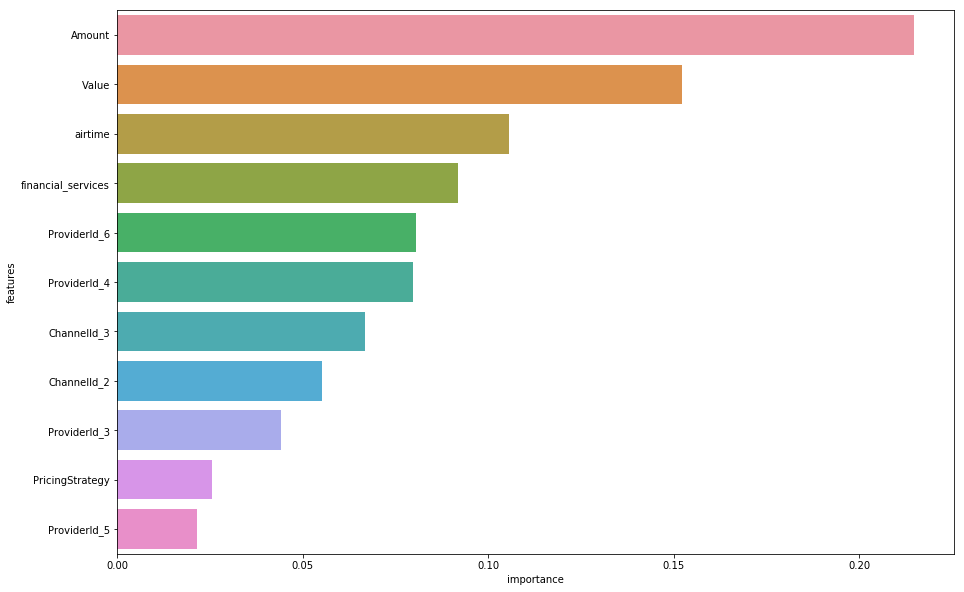

In [334]:
### Performing feature importance with the inbuilt random forest feature importance

def feature_importance(X_train, y_train, threshold = 0.05):
    '''Takes in a pandas dataframe only'''
    from sklearn.ensemble import ExtraTreesClassifier

    # Initialize a random forest estimator
    forest = ExtraTreesClassifier(n_estimators=50,random_state=0)

    # Fit the input matrix and target values to the classifier
    forest.fit(X_train, y_train)

    # Retrieve the computed feature importance
    importances = forest.feature_importances_

    # Plot the feature importance
    plot_data = pd.DataFrame({'features' : pd.Series(X_train.columns),'importance' : pd.Series(importances)})
    plt.figure(figsize=(15,10))
    plot_data = plot_data.sort_values('importance',ascending=False)
    plot_data = plot_data[plot_data['importance'] > threshold]
    ax = sns.barplot(x=plot_data['importance'],y=plot_data['features'])
    plt.show()
    
feature_importance(X_train_bal, y_train_bal, threshold = 0.02)

In [335]:
important_features = ['ProviderId_5', 'PricingStrategy', 'ProviderId_3', 'ChannelId_3', 'ChannelId_2', 'ProviderId_4', 'ProviderId_6', 'financial_services', 'airtime', 'Value', 'Amount']
df = X_train_bal[important_features]
X_test = X_test[important_features]

In [336]:
y_train_bal = pd.DataFrame(y_train_bal, columns = ['FraudResult'])
df_outlier = pd.concat([df, y_train_bal], axis = 1)

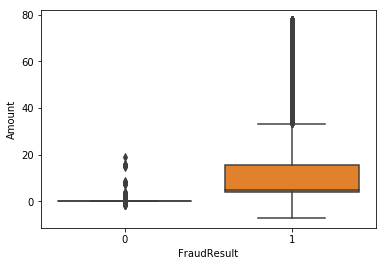

In [337]:
sns.boxplot(x=df_outlier['FraudResult'], y = df_outlier['Amount'])

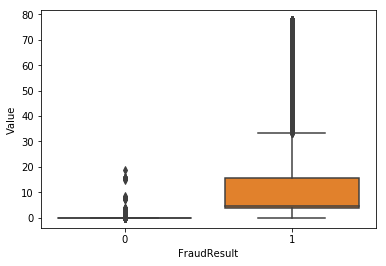

In [338]:
sns.boxplot(x=df_outlier['FraudResult'], y = df_outlier['Value'])

In [339]:
## Using the Z-scores to filter Outliers since out dataset contains outliers as seen in the boxplot above
from scipy import stats

z = np.abs(stats.zscore(df_outlier))

In [340]:
df_z = df_outlier[(z<3).all(axis = 1)]
X_z = df_z.drop(['FraudResult'], axis = 1)
y_z = df_z.FraudResult

In [341]:
#Metric function

## This function takes in some ensemble algorithms and a Stoichatic gradient descent algorithm
## Precision and recall curve is compared to the ROC curve

## For imbalanced dataset, we better look at the precision recall curve and the confusion matrix in other to compare the performance of our algorithm


from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier, LogisticRegression


def result_metric_visual(X_train, X_test, y_train, y_test):
    model_names = ['Random_Forest', 'XGBOOST', 'LightGBM', 'SGD']
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
    rf = RandomForestClassifier()
    xgb = XGBClassifier(base_score = 0.5, max_depth = 7, n_estimators = 200, random_state = 1, subsample = 0.9)
    lgb = LGBMClassifier()
    sgd = SGDClassifier(loss = 'log', alpha = 100, early_stopping = True, n_jobs = -1, l1_ratio = 0.1, fit_intercept = True) ###LGBMClassifier()
    models = [rf, xgb, lgb, sgd]
    for model, k  in zip(models, model_names):
        print('#' * 12, k, '#' * 12)
        print('.' *10, 'Training', '.'*10)
        rfe = RFE(model, n_features_to_select = 7, step = 5)
        rfe = rfe.fit(X_train, y_train)
        y_pred = rfe.predict(X_test)
        y_pred_prob = rfe.predict_proba(X_test)[:,1]
        
        print('...............', 'REPORTS', '...............')
        print('Accuracy on training:-', rfe.score(X_train, y_train))
        print('Accuracy on testing:-', rfe.score(X_test, y_test))
        print('..............Classification Report..........')
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, rfe.predict(X_test))))
        
        
        
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
        avg_pre = average_precision_score(y_test, y_pred_prob)
        
        
        
        ax1.plot(precision, recall, label = k + " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
        ax1.set_xlabel('Precision', fontsize = 14)
        ax1.set_ylabel('Recall', fontsize = 14)
        ax1.set_title('Precision-Recall Curve', fontsize = 18)
        ax1.legend(loc = 'best')
        #default threshold
        close_default = np.argmin(np.abs(thresholds_pr - 0.5))  
    
        fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        ax2.set_title('Receiver Operating Characteristic')
        ax2.plot(fpr, tpr, 'b', label = k+ " area = {:0.2f}".format(roc_auc))
        ax2.legend(loc = 'best')
        ax2.plot([0, 1], [0, 1],'r--')
        ax2.set_xlim([0, 1])
        ax2.set_ylim([0, 1])
        ax2.set_ylabel('True Positive Rate')
        ax2.set_xlabel('False Positive Rate')
        close_default = np.argmin(np.abs(threshold - 0.5))
        plt.tight_layout()

############ Random_Forest ############
.......... Training ..........
............... REPORTS ...............
Accuracy on training:- 0.9972910604996489
Accuracy on testing:- 0.6697851878952595
..............Classification Report..........
              precision    recall  f1-score   support

           0       1.00      0.67      0.80     19098
           1       0.01      0.97      0.01        35

    accuracy                           0.67     19133
   macro avg       0.50      0.82      0.41     19133
weighted avg       1.00      0.67      0.80     19133

Confusion Matrix: 
 [[12781  6317]
 [    1    34]]

############ XGBOOST ############
.......... Training ..........
............... REPORTS ...............
Accuracy on training:- 0.9989833115949299
Accuracy on testing:- 0.6250979982229655
..............Classification Report..........
              precision    recall  f1-score   support

           0       1.00      0.62      0.77     19098
           1       0.00      0.94     

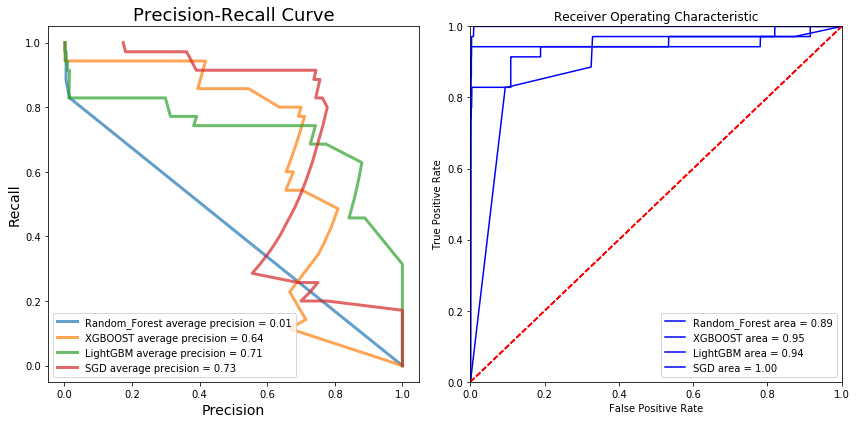

In [321]:
result_metric_visual(X_z, X_test, y_z, y_test)

### Since the SGD algorithm performs better under the P-R curve and the ROC-curve, i further tweek this algorithm to get a better result

In [351]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model = SGDClassifier(loss = 'log', alpha =100, early_stopping = True, n_jobs = -1, l1_ratio = 1, fit_intercept = True)
rfe = RFE(model, n_features_to_select = 7, step = 500)
rfe = rfe.fit(X_z, y_z)
result = rfe.predict(X_test)

In [352]:
print(classification_report(y_test, result))
print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, result)))
print('test accuracy:{}'.format(rfe.score(X_test, y_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19098
           1       0.76      0.89      0.82        35

    accuracy                           1.00     19133
   macro avg       0.88      0.94      0.91     19133
weighted avg       1.00      1.00      1.00     19133

Confusion Matrix: 
 [[19088    10]
 [    4    31]]

test accuracy:0.9992682799351905


#### The above result is achieved even without using gridsearch to find the best parameters for the algorithm

In [62]:
path_test = 'Xente/test.csv'
test = load_data(path_test, date = ['TransactionStartTime'])

Loading Data...............
Data Loaded with Date


In [63]:
test.drop(ids, inplace = True, axis = 1)
test['Fraud_time'] = test['TransactionStartTime'].dt.time
#test['time_of_the_day'] = test['Fraud_time'].apply(time_of_the_day)

In [64]:
product_cat_test = pd.get_dummies(test['ProductCategory'])
provider_id_test = pd.get_dummies(test['ProviderId'])
channel_id_test = pd.get_dummies(test['ChannelId'])
test_test = pd.concat([test, product_cat_test, provider_id_test, channel_id_test], axis = 1)
test_test.drop(['ProviderId', 'ProductId', 'ChannelId',  'ProductCategory', 'TransactionStartTime', 'Fraud_time', 'BatchId', 'ChannelId', 'AccountId', 'SubscriptionId', 'CustomerId'], axis = 1, inplace = True)

In [65]:
test_data_ = scale_pca(test_test)
test_data_ = pd.DataFrame(test_data_, columns = list(test_test.columns) )

Built on the SciKit-learn library


In [66]:
data = test_data_[use]
data.columns

Index(['ProviderId_5', 'PricingStrategy', 'ProviderId_3', 'ChannelId_3',
       'ChannelId_2', 'ProviderId_4', 'ProviderId_6', 'financial_services',
       'airtime', 'Value', 'Amount'],
      dtype='object')

In [67]:
y_predict = rfe.predict(data)
#y_predict = y_predict.reshape(-1, 1)
y_predict.shape

(45019,)

In [68]:
sub = pd.read_csv('Xente/sample_submission.csv')
rest = pd.DataFrame({'TransactionId': sub['TransactionId'], 'FraudResult': y_predict})
rest.to_csv('Xente/xente_sub15.csv', index = False )

In [ ]:
### the method achieved a 0.68 score on the leaderboard